In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
#import pynance as pn
from itertools import permutations

tickers = ['XRP-USD', 'SOL-USD', 'BTC-USD', 'ETH-USD', 'ETC-USD', 'ADA-USD', 'BNB-USD', 'DOGE-USD']

perm = permutations(tickers, 2)

pairs = []

pairs_data = {}

for i in list(perm):

    data = yf.download([i[0], i[1]], start = '2017-01-09', progress = False)['Close']

    data = data.dropna()

    ratio = data[i[0]]/data[i[1]]
    cutoff = round(len(ratio)*.7)

    if adfuller(ratio[:cutoff])[1] < .05:
        pairs.append(i)
    
        pairs_data[i] = data

#data['Ratio'] = ratio

#ratio[:cutoff].plot()
#plt.axhline(np.mean(ratio[:cutoff]))

pairs


[('XRP-USD', 'ETC-USD'),
 ('BTC-USD', 'BNB-USD'),
 ('ETH-USD', 'ADA-USD'),
 ('ETH-USD', 'BNB-USD'),
 ('ETH-USD', 'DOGE-USD'),
 ('ETC-USD', 'XRP-USD'),
 ('ETC-USD', 'BNB-USD'),
 ('ETC-USD', 'DOGE-USD'),
 ('ADA-USD', 'BTC-USD'),
 ('ADA-USD', 'ETH-USD'),
 ('ADA-USD', 'BNB-USD'),
 ('DOGE-USD', 'BNB-USD')]

In [19]:
#eqdata = pn.data.get('TSLA', '2015', '2016')

#ratio = pd.DataFrame(ratio, columns = ['Ratio'], index = ratio.index)

#bolldata, smadata = pn.tech.movave.bollinger(ratio, window = 80, selection='Ratio')

#bolldata['Ratio'] = ratio['Ratio']

#data['Lower'] = bolldata['Lower']
#data['Upper'] = bolldata['Upper']

#plt.figure(figsize=(15,10))
#bolldata.plot()

pairs_data


tickers = pairs[1]

In [20]:

def run_strategy(stuff, lookback, width, ticker1, ticker2):
   #calculating our 63-day hedge ratio lookback window like this makes our program more flexible and readable
   hr_lookback_months = 3
   monthly_trading_days = 21
   hr_lookback = monthly_trading_days * hr_lookback_months
   
   df = stuff.copy()
   
   df['Hedge Ratio'] = df[ticker1].rolling(hr_lookback).corr(df[ticker2]) * (df[ticker1].rolling(hr_lookback).std() / df[ticker2].rolling(hr_lookback).std())
   df['spread'] = df[ticker1] - df['Hedge Ratio'] * df[ticker2]
   
   #BB calculations
   df['rolling_spread'] = df['spread'].rolling(lookback).mean() #lookback-day SMA of spread
   df['rolling_spread_std'] = df['spread'].rolling(lookback).std() #lookback-day rolling STD of spread
   df['Upper'] = df['rolling_spread'] + (width * df['rolling_spread_std']) #upper = SMA + width * STD
   df['Lower'] = df['rolling_spread'] - (width * df['rolling_spread_std']) #lower = SMA - width * STD
   
   df[f'Position {ticker1}'] = np.nan
   
   for date in df.index: #note: this for-loop method is easier to follow, but using np.where() gives a more efficient solution. Look up the documentation!
      if df.loc[date, 'spread'] > df.loc[date, 'Upper']: 
         df.loc[date, f'Position {ticker1}'] = -1
      elif df.loc[date, 'spread'] < df.loc[date, 'Lower']:
         df.loc[date, f'Position {ticker1}'] = 1
      elif (df.loc[date, 'spread'] >= df.loc[date, 'Lower']) & (df.loc[date, 'spread'] <= df.loc[date, 'Upper']):
         df.loc[date, f'Position {ticker1}'] = 0
         
   df[f'Position {ticker2}'] = -df['Hedge Ratio'] * df[f'Position {ticker1}']
   
   df[f'P&L {ticker1}'] = df[f'Position {ticker1}'] * df[ticker1].diff().shift(-1)
   df[f'P&L {ticker2}'] = df[f'Position {ticker2}'] * df[ticker2].diff().shift(-1)
   df['PL'] = df[f'P&L {ticker1}'] + df[f'P&L {ticker2}']
   
   return df


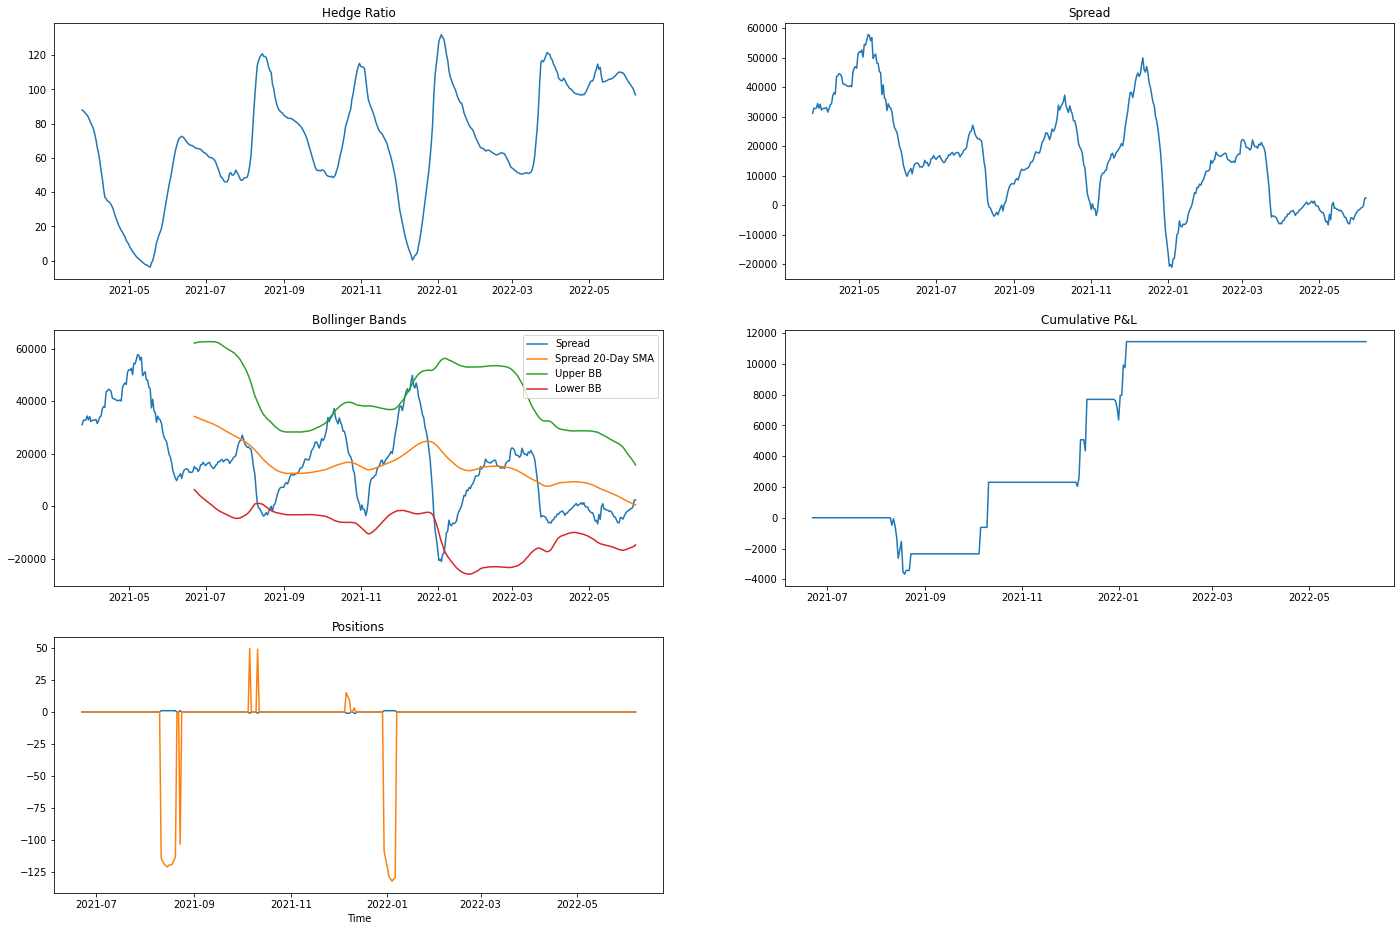

In [21]:
standard_BB_train_df = run_strategy(pairs_data[('BTC-USD', 'BNB-USD')][cutoff:], 90, 2.0, 'BTC-USD', 'BNB-USD')

#plot intermediate and final results of using these parameters on training data
fig = plt.figure(figsize=(24,16)) #overall plot size
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

ax1.plot(standard_BB_train_df['Hedge Ratio'])
ax1.set_title("Hedge Ratio")

ax2.plot(standard_BB_train_df['spread'])
ax2.set_title("Spread")

ax3.plot(standard_BB_train_df['spread'], label = 'Spread')
ax3.plot(standard_BB_train_df['rolling_spread'], label = 'Spread 20-Day SMA')
ax3.plot(standard_BB_train_df['Upper'], label = 'Upper BB')
ax3.plot(standard_BB_train_df['Lower'], label = 'Lower BB')
ax3.set_title("Bollinger Bands")
ax3.legend(loc="upper right")

ax4.plot(standard_BB_train_df['PL'].cumsum()) #note: we use cumsum here to see *cumulative* profit
ax4.set_title("Cumulative P&L")

ax5.plot(standard_BB_train_df[f'Position BTC-USD'], label = tickers[0])
ax5.plot(standard_BB_train_df[f'Position BNB-USD'], label = tickers[1])
ax5.set_title("Positions")

plt.xlabel("Time")
plt.show()

In [18]:


tickers


('XRP-USD', 'ETC-USD')

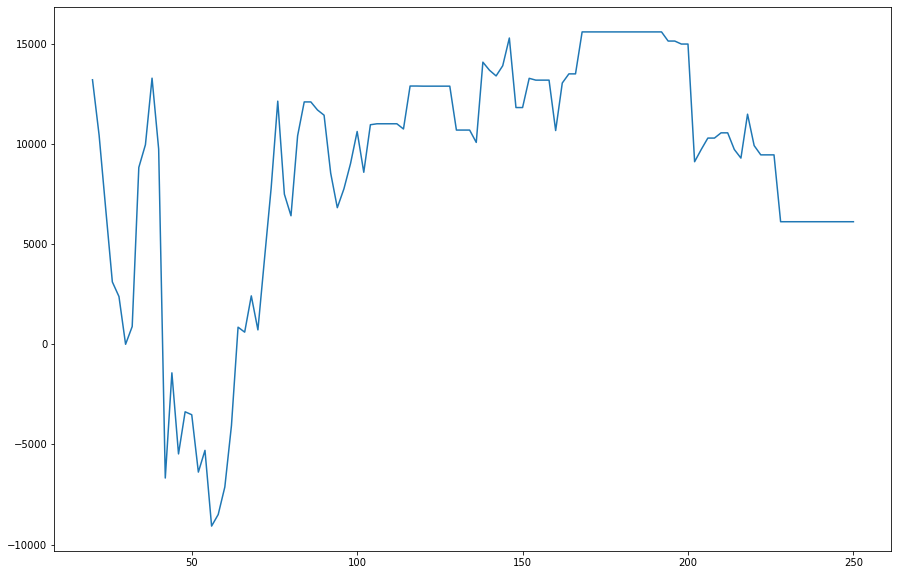

In [22]:
def sharpe(r, rfr):
    
    #print(r.cumsum())
    
    return (r.cumsum()[-2] - rfr) / (np.std(r) * np.sqrt(252))
                                                        

#sharpe(standard_BB_train_df['PL'], .01)
#standard_BB_train_df['PL'].cumsum()[-2]
opt_lookback = []
opt_std = []
tests = [i for i in range(20, 252, 2)]

for i in range(20, 252, 2):
    ok = run_strategy(pairs_data[('BTC-USD', 'BNB-USD')][cutoff:], i, 2.0, tickers[0], tickers[1])
    opt_lookback.append(ok['PL'].cumsum()[-2])

plt.figure(figsize=(15,10))
plt.plot(tests, opt_lookback)

In [23]:
returns = {i : 0.0 for i in pairs}

for i in pairs:
    
    data = yf.download([i[0], i[1]], start = '2017-01-09', progress = False)['Close']

    data = data.dropna()

    ratio = data[i[0]]/data[i[1]]
    cutoff = round(len(ratio)*.7)
    #try:
    standard_BB_train_df = run_strategy(data[cutoff:], 120, 2.0, i[0], i[1])
    #except:
        #print('dang')
    
    returns[i] = standard_BB_train_df['PL'].cumsum()[-2]



In [38]:
from sklearn.preprocessing import MinMaxScaler

data = yf.download(['BTC-USD', 'BNB-USD', "ETH-USD", "ADA-USD"], start = '2017-01-09', progress = False)['Close'].dropna()


#(data['ETH-USD'] / data['BNB-USD'])[200:].plot()

mm = MinMaxScaler()


plt.plot(data['ETH-USD'].index, mm.fit_transform(data['ETH-USD']).reshape(-1,1))
plt.plot(data['BTC-USD'].index, mm.fit_transform(data['BTC-USD']).reshape(-1,1))



ValueError: Expected 2D array, got 1D array instead:
array=[ 320.88400269  299.25299072  314.68099976 ... 1805.20495605 1859.28967285
 1812.57714844].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

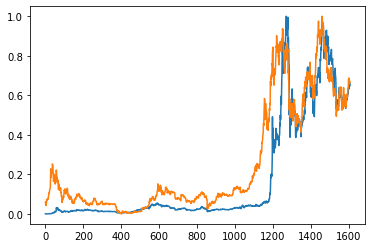

In [18]:

from sklearn.preprocessing import MinMaxScaler

returns

sc = MinMaxScaler()

plt.plot(sc.fit_transform(pairs_data[('BTC-USD', 'BNB-USD')]))

In [24]:
pairs_data[('ETH-USD', 'XRP-USD')].corr()
#pairs_data[('BTC-USD', 'BNB-USD')].corr()



,ETH-USD,XRP-USD
ETH-USD,1.000000,0.658757
XRP-USD,0.658757,1.000000
